# Выполнил Солдатов Вячеслав, Шадай Дарья, М8О-411Б

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [17]:
# загрузка и подготовка данных
from os import listdir

files = listdir("drive/MyDrive/Temp/tpr_lab2_data/")
for i, f in enumerate(files):
    files[i]="drive/MyDrive/Temp/tpr_lab2_data/"+files[i]
print(files)

tickers_data={
    "RASP": [],
    "RUAL": [],
    "KMAZ": [],
    "SBER": [],
    "DSKY": [],
    "GAZP": [],
}

i=0
for k in tickers_data:
    print(files[i])
    tickers_data[k]=pd.read_excel(files[i], usecols="A,B").iloc[::-1].rename(columns={"Bid": k})
    i+=1
    print(tickers_data[k])


['drive/MyDrive/Temp/tpr_lab2_data/sberbank-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/detsky-mir-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/kamaz-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/raspadskaya-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/uc-rusal-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/gazprom-moscow-exchange.xlsx']
drive/MyDrive/Temp/tpr_lab2_data/sberbank-moscow-exchange.xlsx
           Дата    RASP
504  01.04.2020  184.71
503  02.04.2020  186.04
502  03.04.2020  185.52
501  06.04.2020  190.60
500  07.04.2020  197.27
..          ...     ...
4    18.04.2022  123.76
3    19.04.2022  120.36
2    20.04.2022  120.81
1    21.04.2022  118.55
0    22.04.2022  116.90

[505 rows x 2 columns]
drive/MyDrive/Temp/tpr_lab2_data/detsky-mir-moscow-exchange.xlsx
           Дата   RUAL
504  01.04.2020  90.68
503  02.04.2020  90.38
502  03.04.2020  94.24
501  06.04.2020  98.14
500  07.04.2020  98.14
..          ...    ...
4

Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

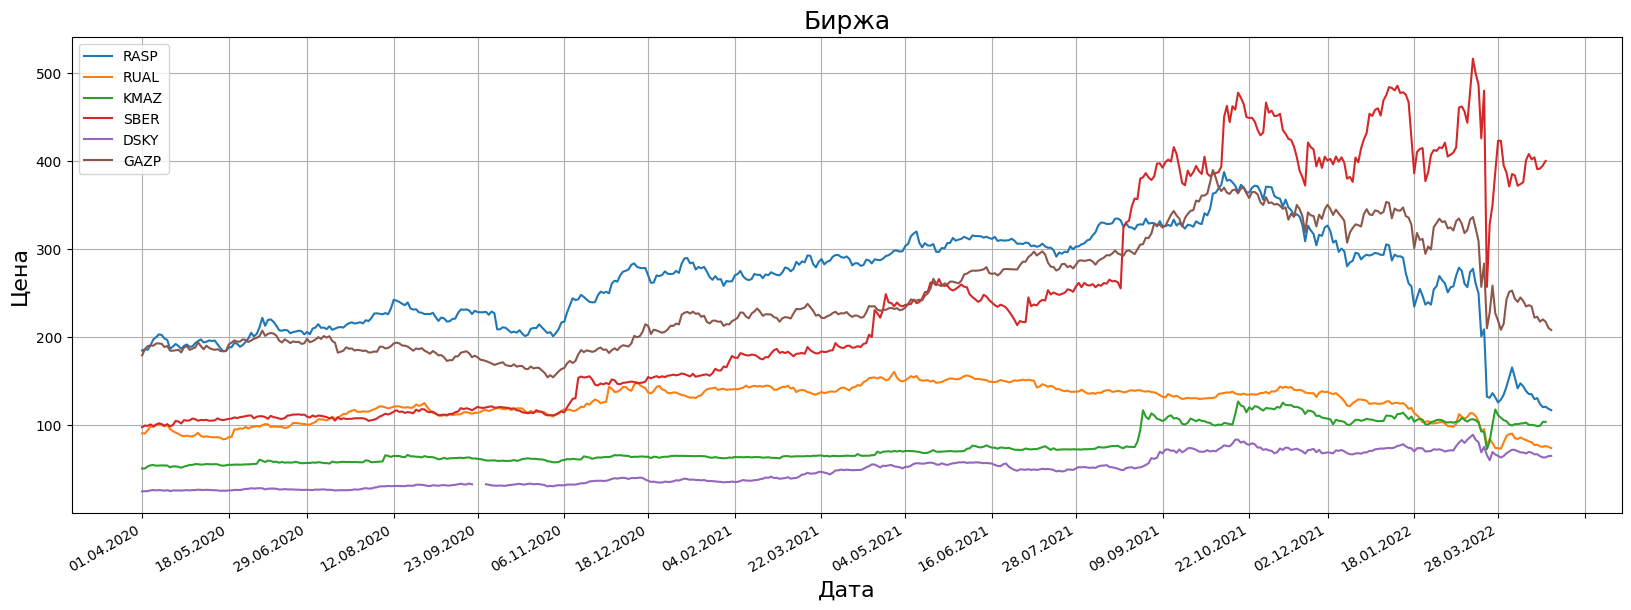

In [18]:
# красивая визуализация на графике с подписями и адекватным масштабом
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

for k in tickers_data:
    tickers_data[k].plot(ax=ax, x="Дата", y=k, kind='line', xlabel="Дата", ylabel="Цена", figsize=(20, 7), grid=True)

plt.gcf().autofmt_xdate()
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Цена', fontsize=16)
plt.title('Биржа', fontsize=18)
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [19]:
for k in tickers_data:
    print(pd.concat([tickers_data[k][k].div(tickers_data[k][k].shift(1)).dropna(), tickers_data[k]["Дата"]], axis=1))

         RASP        Дата
503  1.007200  02.04.2020
502  0.997205  03.04.2020
501  1.027382  06.04.2020
500  1.034995  07.04.2020
499  1.013079  08.04.2020
..        ...         ...
3    0.972527  19.04.2022
2    1.003739  20.04.2022
1    0.981293  21.04.2022
0    0.986082  22.04.2022
504       NaN  01.04.2020

[505 rows x 2 columns]
         RUAL        Дата
503  0.996692  02.04.2020
502  1.042709  03.04.2020
501  1.041384  06.04.2020
500  1.000000  07.04.2020
499  1.016711  08.04.2020
..        ...         ...
3    0.995242  19.04.2022
2    1.010624  20.04.2022
1    0.987911  21.04.2022
0    0.981644  22.04.2022
504       NaN  01.04.2020

[505 rows x 2 columns]
         KMAZ        Дата
501  1.000000  02.04.2020
500  1.047431  03.04.2020
499  1.022642  06.04.2020
498  1.007380  07.04.2020
497  0.985348  08.04.2020
..        ...         ...
3    0.989980  19.04.2022
2    1.003036  20.04.2022
1    1.045409  21.04.2022
0    1.000000  22.04.2022
502       NaN  01.04.2020

[503 rows x 2 c

## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

$$
\nabla f_t(x)=\frac{r^T_t}{r^T_tx}
$$
Алгоритм OGD: \\
for $t=1$ to T: \\
$\quad$ $x_{t+1}=\Pi_D(x_t-a_t\nabla f_i(x_t))=argmin_{x \in D}||x-y||_2 $ \\
end.


Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [20]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [21]:
# реализация онлайн градиентного спуска
for k in tickers_data:
    tickers_data[k][k]=tickers_data[k][k].dropna()


def onlineGradientDescent(parameter, eps):
    x=np.ones(len(tickers_data))/len(tickers_data)
    result=[x.copy()]
    for t in range(len(tickers_data['RASP']['RASP'])):
        r_t=[]
        for k in tickers_data:
            if t in tickers_data[k][k].dropna():
                r_t.append(tickers_data[k][k][t])
                no_data=0;
            else:
                no_data=1;
                break;
        if no_data:
            continue
        x=simplex_projection((-(r_t/(np.dot(x, r_t) + eps)))*parameter)
        result.append(x.copy())
    return np.array(result)

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Выбор шага должен удовлетворять условиям сходимости функции и давать оптимальную границу для регрета.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

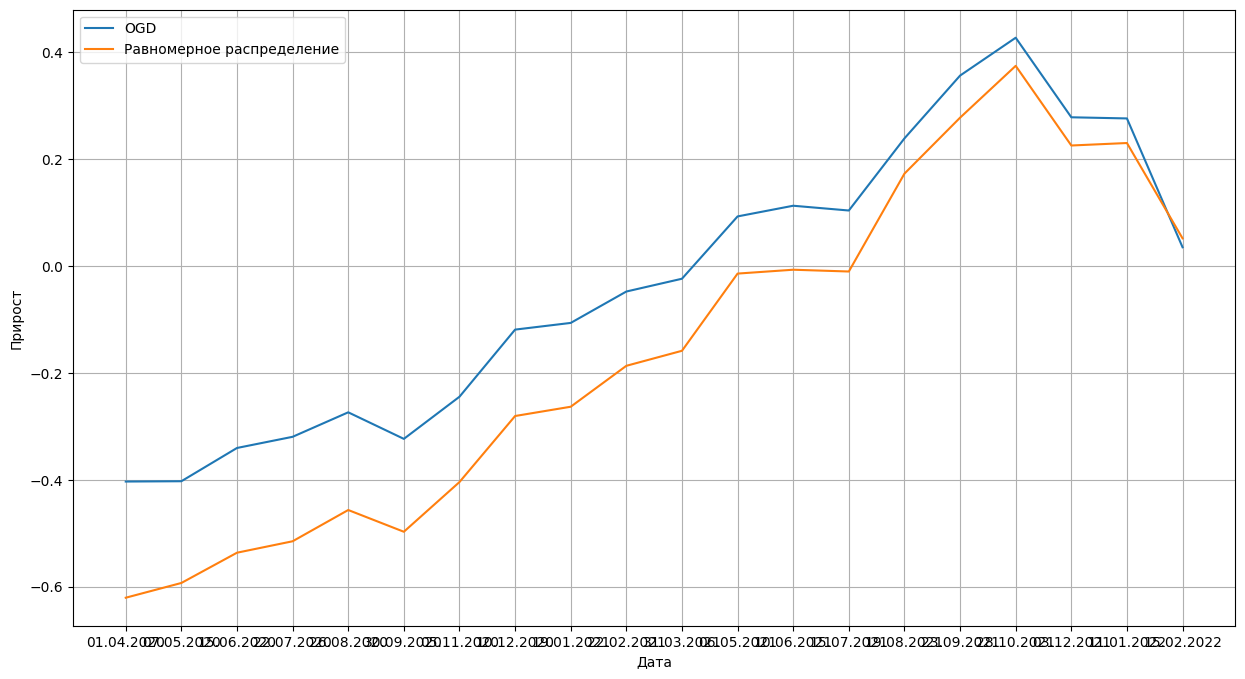

In [70]:
# красивая визуализация на графике с подписями и адекватным масштабом
tickers_data_prices = None
for k in tickers_data:
    tickers_data_prices = pd.concat([tickers_data_prices, tickers_data[k][k]], axis=1).dropna()

tickers_data_prices.loc[503] = tickers_data_prices.loc[499]

ogd_weights = onlineGradientDescent(0.01, 1e-8)
ogd_portfolio = np.sum(ogd_weights * tickers_data_prices, axis=1)
ogd_log_returns = np.log(ogd_portfolio / ogd_portfolio[0])

fixed_weights = np.array([0.2, 0.1, 0.1, 0.3, 0.2, 0.1])
fixed_portfolio = np.sum(fixed_weights * tickers_data_prices, axis=1)
fixed_log_returns = np.log(fixed_portfolio / fixed_portfolio[0])

plt.figure(figsize=(15, 8))
plt.plot(tickers_data["RASP"]["Дата"].iloc[:-5:25], ogd_log_returns.iloc[:-5:25], label="OGD")
plt.plot(tickers_data["RASP"]["Дата"].iloc[:-5:25], fixed_log_returns.iloc[:-5:25], label="Равномерное распределение")
plt.xlabel("Дата")
plt.ylabel("Прирост")
plt.legend()
plt.grid()
plt.show()

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [9]:
# место для кода